# Laboratorium 2 - wieloręcy bandyci

## Przygotowanie

 * [opcjonalnie] Utwórz wirtualne środowisko
 `python3 -m venv ./recsyslab2`
 * zainstaluj potrzebne biblioteki:
 `pip3 install matplotlib tabulate`
 * upewnij się, że plik `bandit_framework.py` najduje się w tym samym katalogu

## Część 1. - framework i naiwni bandyci

In [3]:
# importujemy wszystkie potrzebne pakiety

from copy import copy
from itertools import product
from math import log, sqrt
from tabulate import tabulate
from random import betavariate, normalvariate, random, sample, shuffle, uniform
from bandit_framework import * # pakiet ze srodowiskiem testowym

In [4]:
# inicjalizujemy parametry testu

runs = 50
epochs = 100
recommendation_size = 10

In [5]:
# inicjalizujemy ramiona bandytow - payout kazdego ramienia bedzie reprezentowany przez rozklad normalny
#   te ramiona dobrze reprezentują CTR, czyli funkcje celu o rozkladzie Bernoulliego
#   - mamy prawdopodobienstwo aktywacji (klikniecia) p i staly payout po kliknieciu
# Mozemy takze przygotowac inne typy ramion, np. z payoutem losowanym z rozkladu normalnego lub wykladniczego

good_arms = [Arm(f'good_{i}', uniform(0.5, 0.7), lambda: 1) for i in range(10)]
bad_arms = [Arm(f'bad_{i}', uniform(0.1, 0.4), lambda: 1) for i in range(90)]
all_arms = good_arms+bad_arms
shuffle(all_arms)
arms = {arm.arm_id: arm for arm in all_arms}
arm_ids = list(arms.keys())

In [6]:
expected_highest_payout_per_epoch = sum(sorted([arm.activation_probability for arm in arms.values()], reverse=True)[:10])
print(f'Expected highest average payout per epoch: {expected_highest_payout_per_epoch}')

Expected highest average payout per epoch: 6.015084730373976


In [7]:
# pierwszy bandyta - wybiera losowe ramiona

class Random(Bandit):
    def __init__(self, bandit_id, arm_ids):
        super().__init__(bandit_id, arm_ids)
    
    def recommend(self, size):
        return sample(self.arm_ids, size)
    
    def feedback(self, arm_id, payout):
        pass

In [8]:
# ten bandyta oszukuje - zna mozliwosci kazdego z ramion i wybiera najelpsze - przyda nam sie do porownania

class Perfect(Bandit):
    def __init__(self, bandit_id, arm_ids, arms):
        super().__init__(bandit_id, arm_ids)
        self.arms = arms
        self.expected_payouts = {}
        for arm in arms.values():
            self.expected_payouts[arm.arm_id] = self.__find_expected_value(arm.payout_function) * arm.activation_probability
        self.arm_ids_sorted_by_expected_payout = [x[0] for x in sorted(self.expected_payouts.items(), key=lambda x: x[1], reverse=True)]

    def recommend(self, size):
        return self.arm_ids_sorted_by_expected_payout[:size]
    
    def feedback(self, arm_id, payout):
        pass
    
    def __find_expected_value(self, payout_function, n=100000):
        # brzydka, ale skuteczna sztuczka, zeby metoda brute-force znalexc wartosc oczekiwana
        return sum([payout_function() for i in range(n)]) / n

In [9]:
# tworzymy liste bandytow do przetestowania

bandits = [
    Random('random', arm_ids),
    Perfect('perfect', arm_ids, arms)
]

In [10]:
# uruchamiamy test

runner = Runner(arms, bandits)
results = runner.simulate(runs, epochs, recommendation_size)

Simulating: random
Simulating: perfect



Aggregated results:

perfect: 605.0400000000002
random: 293.0


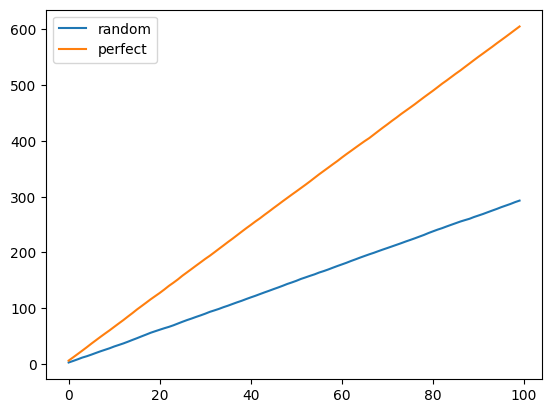

In [11]:
# wyniki sumaryczne dla wszystkich epok

runner.plot_results(results, runs, epochs, mode='cumulative')


Aggregated results:

perfect: 6.08
random: 2.8


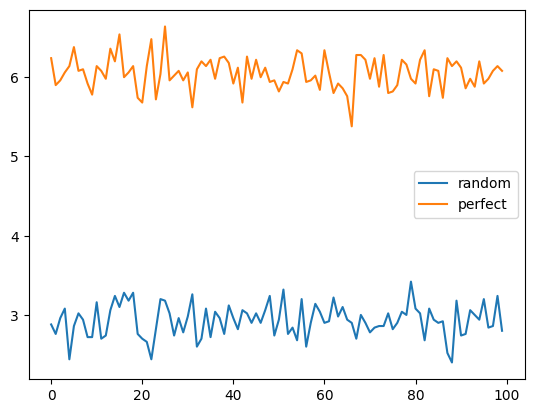

In [12]:
# wyniki per epoka

runner.plot_results(results, runs, epochs, mode='average')

## Część 2. - bandyci właściwi

In [13]:
class EGreedy(Bandit):
    def __init__(self, bandit_id, arm_ids, epsilon):
        super().__init__(bandit_id, arm_ids)
        self.epsilon = epsilon

        self.recommended_rates = {arm_id: 0 for arm_id in arm_ids}
        self.activation_rates = {arm_id: 0 for arm_id in arm_ids}
        self.payouts = {arm_id: 0.0 for arm_id in arm_ids}
        self.payouts_per_recommendation = {arm_id: 0.0 for arm_id in arm_ids}
    
    def recommend(self, size):    
        
        #actualization of best_list and new random_list
        best_list = sorted(self.payouts_per_recommendation.items(), key=lambda x : -x[1])
        random_list = sample(list(self.payouts_per_recommendation.items()), len(self.payouts_per_recommendation))
        
        #choose new recomendation 
        #using extra variable 'j' to run into duplicates the least times
        recommendations = []
        j = 0
        for i in range(size):
            while True:
                sample_recommend = best_list[i+j][0] if random()>self.epsilon else random_list[i+j][0]
                if(sample_recommend not in recommendations): break
                j+=1
                    
            self.recommended_rates[sample_recommend] += 1
            recommendations.append(sample_recommend)
        return recommendations
    
    def feedback(self, arm_id, payout):
        self.activation_rates[arm_id] += 1
        self.payouts[arm_id] += payout
        self.payouts_per_recommendation[arm_id] = self.payouts[arm_id]/self.recommended_rates[arm_id]

In [14]:
class UCB(Bandit):
    def __init__(self, bandit_id, arm_ids, optimism_weight):
        super().__init__(bandit_id, arm_ids)
        self.optimism_weight = optimism_weight

        self.recommended_rates = {arm_id: 0 for arm_id in arm_ids}
        self.activation_rates = {arm_id: 0 for arm_id in arm_ids}
        self.payouts = {arm_id: 0.0 for arm_id in arm_ids}
        self.payouts_per_recommendation = {arm_id: 0.0 for arm_id in arm_ids}
        self.n = 0

    def recommend(self, size):
        for arm in self.payouts.keys():
            if self.recommended_rates[arm]>0.0:
                self.payouts_per_recommendation[arm] = self.payouts[arm]/self.recommended_rates[arm]
        self.last_recommended = []
        
        best_list = sorted(self.payouts_per_recommendation.items(), key=lambda x : x[1] + self.optimism_weight*self.optimism(x[0]), reverse=True)

        recommendations = list(map(lambda x: x[0], best_list[:size]))
        for r in recommendations:
            self.recommended_rates[r] += 1
        
        return recommendations
    
    def feedback(self, arm_id, payout):
        self.activation_rates[arm_id] += 1
        self.payouts[arm_id] += payout
        self.n += 1

    def optimism(self, arm_id):
        return sqrt(2*log(self.n)/self.activation_rates[arm_id]) if self.activation_rates[arm_id]!=0 else float('+inf')


In [15]:
class ThompsonSampling(Bandit):
    def __init__(self, bandit_id, arm_ids, reward_multiplier, regret_multiplier):
        super().__init__(bandit_id, arm_ids)
        self.reward_multiplier = reward_multiplier
        self.regret_multiplier = regret_multiplier
        self.a = {arm_id: 1 for arm_id in arm_ids}
        self.b = {arm_id: 1 for arm_id in arm_ids}
    
    def recommend(self, size):
        beta = {arm_id: betavariate(self.a[arm_id], self.b[arm_id]) for arm_id in self.arm_ids}
        best = list(map(lambda x: x[0], sorted(beta.items(), key=lambda x: x[1], reverse=True)))[:size]
        # zwiększamy regeret multiplier zeby nie pominąć tych które nie wywołają feedbacku
        for b in best:
            self.b[b] += self.regret_multiplier
        return best
    
    def feedback(self, arm_id, payout):
        self.a[arm_id] += payout*self.reward_multiplier
        # zmniejszamy z powrotem zwiększony wcześniej regret multiplier
        self.b[arm_id] -= 1*self.regret_multiplier

## Część 3. - zgrubne porównanie bandytów

In [16]:
bandits = [
    Random('random', arm_ids),
    Perfect('perfect', arm_ids, arms)
]
# nie wahaj sie wybrac innych wartosci parametrow bandytow
bandits.extend([EGreedy('egreedy_%s' % epsilon, arm_ids, epsilon) for epsilon in [0.01, 0.05, 0.1, 0.25]])
bandits.extend([UCB('ucb_%s' % optimism_weight, arm_ids, optimism_weight) for optimism_weight in [0.01, 0.1, 1, 10]])
bandits.extend([ThompsonSampling('ts_%s_%s' % (reward_weight, regret_weight), arm_ids, reward_weight, regret_weight)
                for reward_weight, regret_weight in product([1, 5, 10, 20, 50], [1, 5, 10, 20, 50])])

In [17]:
runner = Runner(arms, bandits)
results = runner.simulate(runs, epochs, recommendation_size)

Simulating: random
Simulating: perfect
Simulating: egreedy_0.01
Simulating: egreedy_0.05
Simulating: egreedy_0.1
Simulating: egreedy_0.25
Simulating: ucb_0.01
Simulating: ucb_0.1
Simulating: ucb_1
Simulating: ucb_10
Simulating: ts_1_1
Simulating: ts_1_5
Simulating: ts_1_10
Simulating: ts_1_20
Simulating: ts_1_50
Simulating: ts_5_1
Simulating: ts_5_5
Simulating: ts_5_10
Simulating: ts_5_20
Simulating: ts_5_50
Simulating: ts_10_1
Simulating: ts_10_5
Simulating: ts_10_10
Simulating: ts_10_20
Simulating: ts_10_50
Simulating: ts_20_1
Simulating: ts_20_5
Simulating: ts_20_10
Simulating: ts_20_20
Simulating: ts_20_50
Simulating: ts_50_1
Simulating: ts_50_5
Simulating: ts_50_10
Simulating: ts_50_20
Simulating: ts_50_50



Aggregated results:

perfect: 5.88
ucb_0.1: 5.8
egreedy_0.1: 5.66
egreedy_0.25: 5.4
egreedy_0.05: 5.38
egreedy_0.01: 5.36
ts_1_1: 5.32
ucb_0.01: 5.24
ucb_1: 5.14
ts_20_10: 5.08
ts_1_10: 4.96
ts_5_10: 4.94
ts_10_1: 4.94
ts_5_5: 4.92
ts_10_20: 4.92
ts_20_50: 4.84
ts_5_50: 4.8
ts_5_20: 4.78
ts_10_50: 4.76
ts_1_20: 4.74
ts_1_5: 4.66
ts_1_50: 4.5
ts_50_20: 4.46
ts_10_5: 4.24
ts_50_10: 4.24
ts_50_1: 4.16
ts_10_10: 4.14
ts_20_5: 4.1
ts_5_1: 4.08
ts_20_20: 3.8
ts_20_1: 3.78
ts_50_5: 3.74
ts_50_50: 3.32
random: 3.18
ucb_10: 2.66


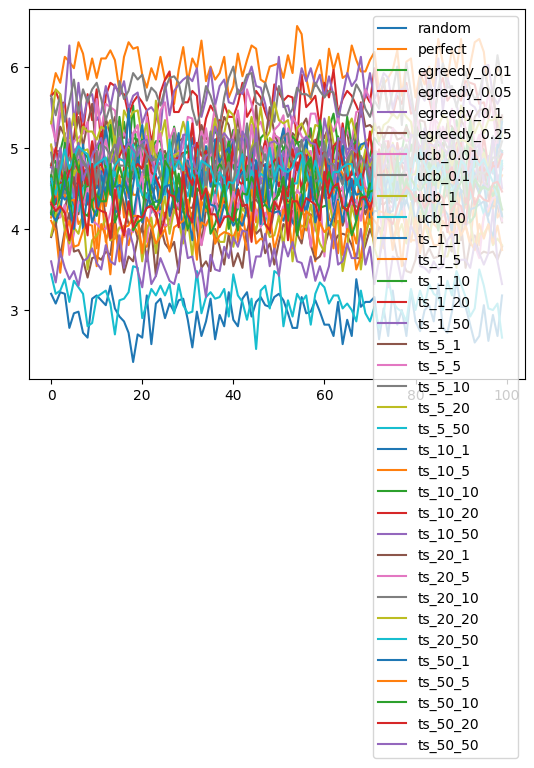

In [18]:
runner.plot_results(results, runs, epochs, mode='average')


Aggregated results:

perfect: 598.8999999999999
egreedy_0.1: 566.1
ucb_0.1: 565.1400000000002
egreedy_0.05: 555.5999999999997
ucb_0.01: 521.38
ucb_1: 520.9999999999999
egreedy_0.25: 515.54
egreedy_0.01: 496.12000000000006
ts_10_50: 494.02000000000015
ts_5_5: 487.17999999999995
ts_1_10: 483.77999999999986
ts_20_10: 483.05999999999983
ts_5_20: 481.17999999999995
ts_1_1: 480.5400000000002
ts_5_10: 478.82000000000005
ts_10_20: 478.0800000000001
ts_1_50: 477.8799999999999
ts_20_50: 469.95999999999987
ts_1_20: 469.23999999999995
ts_5_50: 452.9199999999999
ts_10_1: 452.22
ts_1_5: 449.5
ts_10_10: 446.2199999999998
ts_50_10: 439.22
ts_50_20: 429.02
ts_5_1: 428.46000000000004
ts_50_1: 428.2000000000002
ts_20_5: 418.2999999999999
ts_10_5: 413.14000000000004
ts_20_20: 399.24
ts_50_5: 395.3800000000001
ts_20_1: 380.4599999999999
ts_50_50: 362.21999999999997
ucb_10: 313.08000000000015
random: 295.2400000000001


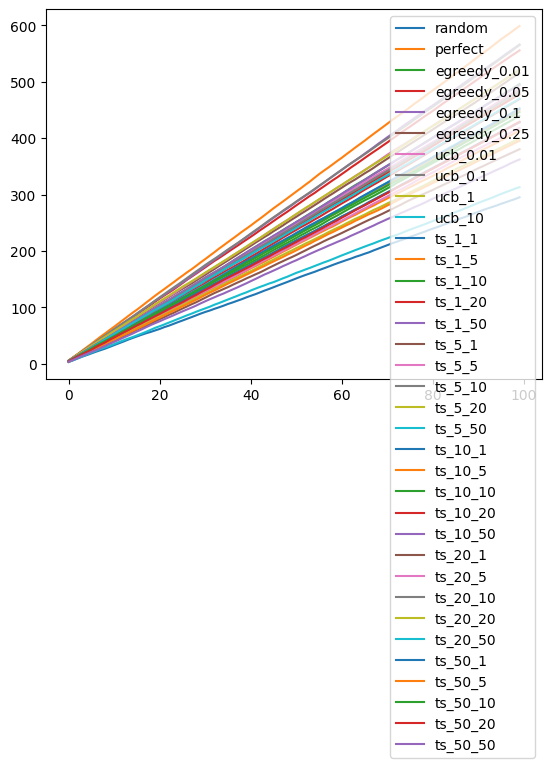

In [19]:
runner.plot_results(results, runs, epochs, mode='cumulative')

## Część 4. - dokładne porównanie bandytów

In [20]:
# obliczmy liste wszystkich dobrych ramion (arm_id zaczyna sie od 'good_') w rekomendacji
def relevant(recommendation: List[Arm]) -> int:
    return len([arm for arm in recommendation if arm.arm_id.startswith('good')])

all_relevant = relevant(arms.values())

In [21]:
# obliczmy precision@k i recall@k (na bazie funkcji relevant())
def precision_at_k(recommendation: List[Arm], k: int) -> float:
    recommendation_relevant = relevant(recommendation)
    return recommendation_relevant/k

def recall_at_k(recommendation: List[Arm], k: int, all_relevant: int) -> float:
    recommendation_relevant = relevant(recommendation) 
    return recommendation_relevant/all_relevant

In [22]:
# sprawdzmy, czy dziala
sample_bandit = bandits[-1]
k = 3
recommendation_ids = sample_bandit.recommend(recommendation_size)
recommendation = [arms[arm_id] for arm_id in recommendation_ids]
print(f'Precision@{k} for bandit {sample_bandit.bandit_id}: {precision_at_k(recommendation, k)}')
print(f'Recall@{k} for bandit {sample_bandit.bandit_id}: {recall_at_k(recommendation, k, all_relevant)}')

Precision@3 for bandit ts_50_50: 0.6666666666666666
Recall@3 for bandit ts_50_50: 0.2


In [25]:
class TestEntry():
    def __init__(self, bandit_name: str, k: int, precision: float, recall: float):
        self.bandit_name = bandit_name
        self.k = k
        self.precision = precision
        self.recall = recall
    
    def tuple(self):
        return (self.bandit_name, self.k, self.precision, self.recall)


def print_test_results(entries: List[TestEntry]):
    data = sorted(sorted([e.tuple() for e in entries], key=lambda e: e[1]), key=lambda e: e[0])
    headers = ('bandit', 'k', 'precision@k', 'recall@k')
    # for i in data:
    #     print(i)
    return tabulate(data, headers, tablefmt='github')

In [26]:
# wybieramy kilku istniejacych, wytrenowanych bandytow (perfect, random, po jednym e-greedy, UCB, TS)
tesing_bandits: List[Bandit] = [
    Random('random', arm_ids),
    Perfect('perfect', arm_ids, arms),
    EGreedy(f'egreedy {0.1}', arm_ids, 0.1),
    UCB(f'ucb {0.1}', arm_ids, 0.1),
    ThompsonSampling(f'thomspson {1}-{20}', arm_ids, 1, 20) ]

# wybieramy wartosci k do porownania
k_vals = [3, 5, 10]
# bedziemy liczyc sredni precision i recall dla `samples` rekomendacji
samples = 10
# miejsce na wyniki
results = []

runner = Runner(arms, tesing_bandits)
runner.simulate(1, epochs, recommendation_size)

for bandit in tesing_bandits:
    precision_sum = [0 for _ in range(len(k_vals))]
    recall_sum = [0 for _ in range(len(k_vals))]
    for _ in range(samples):
        recommendation_ids = bandit.recommend(recommendation_size)
        recommendation = [arms[arm_id] for arm_id in recommendation_ids]
        for i, k in enumerate(k_vals):
            precision_sum[i] += precision_at_k(recommendation[:k], k)
            recall_sum[i] += recall_at_k(recommendation[:k], k, all_relevant)
    for i, k in enumerate(k_vals):
        results.append(TestEntry(bandit.bandit_id, k, precision_sum[i]/samples, recall_sum[i]/samples))

print(print_test_results(results))
# print(results)

Simulating: random
Simulating: perfect
Simulating: egreedy 0.1
Simulating: ucb 0.1
Simulating: thomspson 1-20
| bandit         |   k |   precision@k |   recall@k |
|----------------|-----|---------------|------------|
| egreedy 0.1    |   3 |      0.866667 |       0.26 |
| egreedy 0.1    |   5 |      0.9      |       0.45 |
| egreedy 0.1    |  10 |      0.45     |       0.45 |
| perfect        |   3 |      1        |       0.3  |
| perfect        |   5 |      1        |       0.5  |
| perfect        |  10 |      1        |       1    |
| random         |   3 |      0.166667 |       0.05 |
| random         |   5 |      0.16     |       0.08 |
| random         |  10 |      0.15     |       0.15 |
| thomspson 1-20 |   3 |      0.166667 |       0.05 |
| thomspson 1-20 |   5 |      0.12     |       0.06 |
| thomspson 1-20 |  10 |      0.13     |       0.13 |
| ucb 0.1        |   3 |      1        |       0.3  |
| ucb 0.1        |   5 |      1        |       0.5  |
| ucb 0.1        |  10 |  